# Econ 323 Final Project:
## Fuel Efficiency of Canadian Vehicles

## Introduction

With gasoline prices near record highs, fuel efficiency is a key concern for consumers who need to buy a vehicle. The goal of this research project is to explore fuel efficiency of Canadian vehicles and answer the following questions:

1. How has fuel efficiency across vehicle manufactures changed over time?
2. Which manufacturers have the highest average fuel consumption across all their vehicles?
3. Are changes in fuel efficiency for a manufacturer related to R&D spending?
4. Can existing fuel efficiency information be used to predict future fuel efficiency?
5. ...?


## Outline

1. **Importing and cleaning the data** 


2. **Exploring the Effect Of Each Explanatory Variable In Isolation**

    a. **Raw effects** 
    
    b. **Temporal effects** 
    
    c. **Correlations** 
    
    d. **General findings** 
    
    
3. **Fitting Models**


## 1. Importing and cleaning the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import patsy
import math
from sklearn import (linear_model, metrics, tree, model_selection)
from itertools import cycle

sns.set_palette("muted")
sns.set_style("darkgrid")
pd.set_option('display.max_rows', 100)

%matplotlib inline

In [2]:
# read in csv files
fuel_cons_2023 = pd.read_csv("https://www.nrcan.gc.ca/sites/nrcan/files/oee/files/csv/MY2023%20Fuel%20Consumption"
                             + "%20Ratings.csv", encoding="Windows-1252", low_memory=False)
fuel_cons_2022 = pd.read_csv("https://www.nrcan.gc.ca/sites/nrcan/files/oee/files/csv/MY2022%20Fuel%20Consumption"
                             + "%20Ratings.csv", encoding="Windows-1252", low_memory=False)
fuel_cons_2021 = pd.read_csv("https://www.nrcan.gc.ca/sites/nrcan/files/oee/files/csv/MY2021%20Fuel%20Consumption"
                             + "%20Ratings.csv", encoding="Windows-1252", low_memory=False)
fuel_cons_2020 = pd.read_csv("https://www.nrcan.gc.ca/sites/nrcan/files/oee/files/csv/MY2020%20Fuel%20Consumption"
                             + "%20Ratings.csv", encoding="Windows-1252", low_memory=False)
fuel_cons_2019 = pd.read_csv("https://www.nrcan.gc.ca/sites/nrcan/files/oee/files/csv/MY2019%20Fuel%20Consumption"
                             + "%20Ratings.csv", encoding="Windows-1252", low_memory=False)
fuel_cons_2018 = pd.read_csv("https://www.nrcan.gc.ca/sites/nrcan/files/oee/files/csv/MY2018%20Fuel%20Consumption"
                             + "%20Ratings.csv", encoding="Windows-1252", low_memory=False)
fuel_cons_2017 = pd.read_csv("https://www.nrcan.gc.ca/sites/nrcan/files/oee/files/csv/MY2017%20Fuel%20Consumption"
                             + "%20Ratings.csv", encoding="Windows-1252", low_memory=False)
fuel_cons_2016 = pd.read_csv("https://www.nrcan.gc.ca/sites/nrcan/files/oee/files/csv/MY2016%20Fuel%20Consumption"
                             + "%20Ratings.csv", encoding="Windows-1252", low_memory=False)
fuel_cons_2015 = pd.read_csv("https://www.nrcan.gc.ca/sites/nrcan/files/oee/files/csv/MY2015%20Fuel%20Consumption"
                             + "%20Ratings.csv", encoding="Windows-1252", low_memory=False)
fuel_cons_2010_2014 = pd.read_csv("https://www.nrcan.gc.ca/sites/www.rncan.gc.ca/files/oee/files/csv/MY2010-2014"
                             + "%20Fuel%20Consumption%20Ratings%205-cycle.csv", encoding="Windows-1252", 
                                  low_memory=False)
fuel_cons_2005_2009 = pd.read_csv("https://www.nrcan.gc.ca/sites/www.rncan.gc.ca/files/oee/files/csv/MY2005-2009"
                             + "%20Fuel%20Consumption%20Ratings%205-cycle.csv", encoding="Windows-1252", 
                                  low_memory=False)
fuel_cons_2000_2004 = pd.read_csv("https://www.nrcan.gc.ca/sites/www.rncan.gc.ca/files/oee/files/csv/MY2000-2004"
                             + "%20Fuel%20Consumption%20Ratings%205-cycle.csv", encoding="Windows-1252", 
                                  low_memory=False)


In [3]:
# drop nas and combine datasets from each year
list_of_fuel_data = [fuel_cons_2023, fuel_cons_2022, fuel_cons_2021, fuel_cons_2020, fuel_cons_2019,
                    fuel_cons_2018, fuel_cons_2017, fuel_cons_2016, fuel_cons_2015, fuel_cons_2010_2014,
                    fuel_cons_2005_2009, fuel_cons_2000_2004]

col_names = ["model_year", "make", "model", "vehicle_class", "engine_size_L", "cylinders", "transmission", 
             "fuel_type", "city_fuel_cons", "hwy_fuel_cons", "comb_lpkm", "comb_mpg", "co2_emissions", 
             "co2_rating","smog_rating"]

for i, dataset in enumerate(list_of_fuel_data):
    # drop rows of entirely NaN, then cols of entirely Nan, then rows with some NaN
    # there was ~50 rows at the bottom with text explaining the data, hence the need for the last drop
    dataset = dataset.dropna(axis=0, how='all').dropna(axis=1, how='all').dropna(axis=0)
    try: 
        dataset.columns = col_names
    # older datasets are missing the last one or two cols
    except ValueError:
        try: 
            dataset.columns = col_names[:-1]
        except ValueError:
            dataset.columns = col_names[:-2]
    list_of_fuel_data[i] = dataset
            
full_dataset = pd.DataFrame()

for dataset in list_of_fuel_data:
    full_dataset = pd.concat([full_dataset, dataset], axis=0)
    
full_dataset.reset_index(drop=True, inplace=True)

# drop city and highway fuel consumption as combined fuel consumption represents their weighted average 
#.  (55% city, 45% highway)
# also drop the combined miles per gallon as we will use units of L/100 km
# we will then also drop items related to CO2 emissions, CO2 rating, and smog rating
full_dataset.drop(["city_fuel_cons", "hwy_fuel_cons", "comb_mpg", "co2_emissions", "co2_rating", "smog_rating"], 
                  axis=1, inplace=True)
full_dataset

,model_year,make,model,vehicle_class,engine_size_L,cylinders,transmission,fuel_type,comb_lpkm
0,2023,Acura,Integra,Full-size,1.5,4.0,AV7,Z,7.2
1,2023,Acura,Integra A-SPEC,Full-size,1.5,4.0,AV7,Z,7.4
2,2023,Acura,Integra A-SPEC,Full-size,1.5,4.0,M6,Z,7.8
3,2023,Acura,MDX SH-AWD,SUV: Small,3.5,6.0,AS10,Z,11.2
4,2023,Acura,MDX SH-AWD Type S,SUV: Standard,3.0,6.0,AS10,Z,12.4
...,...,...,...,...,...,...,...,...,...
23477,2004,VOLVO,V70 T5 TURBO,STATION WAGON - MID-SIZE,2.3,5.0,AS5,Z,12.5
23478,2004,VOLVO,V70 T5 TURBO,STATION WAGON - MID-SIZE,2.3,5.0,M5,Z,11.8
23479,2004,VOLVO,XC70 AWD TURBO,SUV,2.5,5.0,AS5,Z,12.5
23480,2004,VOLVO,XC90 2.5T AWD TURBO,SUV,2.5,5.0,AS5,Z,13.0


In [4]:
# convert object datatypes to numerical
full_dataset["model_year"] = full_dataset["model_year"].astype(int)
cols = ["engine_size_L", "comb_lpkm"]
full_dataset[cols] = full_dataset[cols].astype(float)

In [5]:
# clean the 'make' series

# different capitalizations of makes were used in different years. Update for consistency.
full_dataset["make"] = full_dataset["make"].str.title()

# also adjust to account for Dodge rebranding their pickup trucks under the Ram name
full_dataset["make"].replace({"Ram": "Dodge"}, inplace = True)

# remove data from the datset for manufacturers that didn't make cars from 2000 to 2023
makes = full_dataset.groupby("make")
for make in makes.groups:
    matches_make = (full_dataset["make"] == make)
    only_current_make_dataset = full_dataset[matches_make]
    min_year = only_current_make_dataset["model_year"].min()
    max_year = only_current_make_dataset["model_year"].max()
    not_full_range_of_years = ((min_year != 2000) or (max_year != 2023))
    if not_full_range_of_years:
        full_dataset.drop(only_current_make_dataset.index, inplace=True)
full_dataset.reset_index(drop=True, inplace=True)

# verify changes
full_dataset["make"].unique()

array(['Acura', 'Audi', 'Bmw', 'Buick', 'Cadillac', 'Chevrolet',
       'Chrysler', 'Dodge', 'Ford', 'Gmc', 'Honda', 'Hyundai', 'Infiniti',
       'Jaguar', 'Jeep', 'Kia', 'Land Rover', 'Lexus', 'Lincoln', 'Mazda',
       'Mercedes-Benz', 'Nissan', 'Subaru', 'Toyota', 'Volkswagen',
       'Volvo'], dtype=object)

In [6]:
# clean the 'vehicle_class' series

# we are going to simplify into 5 categories: Car, SUV, Van, Truck, and Passenger/Cargo Van
full_dataset["vehicle_class"].replace({"Full-size": "Car",
                                       "SUV: Small": "SUV",
                                       "SUV: Standard": "SUV",
                                       "Compact": "Car",
                                       "Subcompact": "Car",
                                       "Station wagon: Small": "Car",
                                       "Mid-size": "Car",
                                       "Station wagon: Mid-size": "Car",
                                       "Two-seater": "Car",
                                       "Pickup truck: Standard": "Truck",
                                       "Minivan": "Van",
                                       "Pickup truck: Small": "Truck",
                                       "Special purpose vehicle": "Passenger/Cargo Van",
                                       "Minicompact": "Car",
                                       "Van: Passenger": "Passenger/Cargo Van",
                                       "COMPACT": "Car",
                                       "SUV - SMALL": "SUV",
                                       "TWO-SEATER": "Car",
                                       "MID-SIZE": "Car",
                                       "SUBCOMPACT": "Car",
                                       "STATION WAGON - SMALL": "Car",
                                       "FULL-SIZE": "Car",
                                       "SUV - STANDARD": "SUV",
                                       "SPECIAL PURPOSE VEHICLE": "Van",
                                       "PICKUP TRUCK - SMALL": "Truck",
                                       "VAN - PASSENGER": "Passenger/Cargo Van",
                                       "PICKUP TRUCK - STANDARD": "Truck",
                                       "MINIVAN": "Van",
                                       "STATION WAGON - MID-SIZE": "Car",
                                       "MINICOMPACT": "Car",
                                       "SUV": "SUV",
                                       "VAN - CARGO": "Passenger/Cargo Van",
                                       "UL": "SUV"}, inplace = True)

# remove the passenger/cargo van category as these are typically business vehicles
is_passenger_cargo_van = full_dataset["vehicle_class"] == "Passenger/Cargo Van"
only_passenger_cargo_van_dataset = full_dataset[is_passenger_cargo_van]
full_dataset.drop(only_passenger_cargo_van_dataset.index, inplace=True)
full_dataset.reset_index(drop=True, inplace=True)

# verify changes
full_dataset["vehicle_class"].unique()

array(['Car', 'SUV', 'Truck', 'Van'], dtype=object)

In [7]:
# clean the 'fuel_type' series

# update the fuel types from letters to their actual meanings
full_dataset["fuel_type"].replace({"X": "Regular Gasoline",
                                   "Z": "Premium Gasoline",
                                   "D": "Diesel",
                                   "E": "Ethanol",
                                   "N": "Natural Gas"}, inplace = True)

# verify changes
full_dataset["fuel_type"].unique()

array(['Premium Gasoline', 'Regular Gasoline', 'Diesel', 'Ethanol',
       'Natural Gas'], dtype=object)

In [8]:
# clean the 'transmission' series

# separate each into the transmission type and gears
def convert_transmission_to_type(s):
    transmission_type = re.findall('([A-Za-z]+)', s)
    return transmission_type[0]

def convert_transmission_to_gears(s):
    transmission_gears = re.findall('\d+', s)
    if (transmission_gears == []):
        transmission_gears = [1]  
    return transmission_gears[0]

# separate the transmission column into separate columns for transmission type and gears, remove original column
full_dataset["transmission_type"] = full_dataset["transmission"].apply(convert_transmission_to_type)
full_dataset["transmission_gears"] = full_dataset["transmission"].apply(convert_transmission_to_gears)
full_dataset["transmission_gears"] = full_dataset["transmission_gears"].astype(int)
full_dataset.drop(["transmission"], axis=1, inplace=True)

# update the transmission types from abbreviations to their actual meanings
full_dataset["transmission_type"].replace({"A": "Automatic",
                                           "AM": "Automated Manual",
                                           "AS": "Automatic Select Shift",
                                           "AV": "Continuously Variable",
                                           "M": "Manual",}, inplace = True)

# verify changes
full_dataset.head()

,model_year,make,model,vehicle_class,engine_size_L,cylinders,fuel_type,comb_lpkm,transmission_type,transmission_gears
0,2023,Acura,Integra,Car,1.5,4.0,Premium Gasoline,7.2,Continuously Variable,7
1,2023,Acura,Integra A-SPEC,Car,1.5,4.0,Premium Gasoline,7.4,Continuously Variable,7
2,2023,Acura,Integra A-SPEC,Car,1.5,4.0,Premium Gasoline,7.8,Manual,6
3,2023,Acura,MDX SH-AWD,SUV,3.5,6.0,Premium Gasoline,11.2,Automatic Select Shift,10
4,2023,Acura,MDX SH-AWD Type S,SUV,3.0,6.0,Premium Gasoline,12.4,Automatic Select Shift,10


In [9]:
# reorder the columns
full_dataset = full_dataset[["model_year", "make", "model", "vehicle_class", "fuel_type",
                             "engine_size_L", "cylinders", "transmission_type", 
                             "transmission_gears", "comb_lpkm"]]

# verify changes
full_dataset.head()

,model_year,make,model,vehicle_class,fuel_type,engine_size_L,cylinders,transmission_type,transmission_gears,comb_lpkm
0,2023,Acura,Integra,Car,Premium Gasoline,1.5,4.0,Continuously Variable,7,7.2
1,2023,Acura,Integra A-SPEC,Car,Premium Gasoline,1.5,4.0,Continuously Variable,7,7.4
2,2023,Acura,Integra A-SPEC,Car,Premium Gasoline,1.5,4.0,Manual,6,7.8
3,2023,Acura,MDX SH-AWD,SUV,Premium Gasoline,3.5,6.0,Automatic Select Shift,10,11.2
4,2023,Acura,MDX SH-AWD Type S,SUV,Premium Gasoline,3.0,6.0,Automatic Select Shift,10,12.4


## 2. Exploring the Effect Of Each Explanatory Variable In Isolation
### a. Raw effects

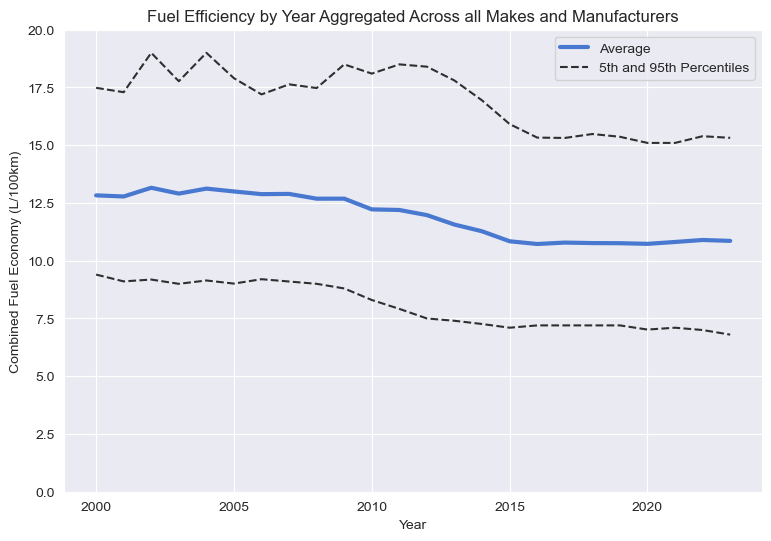

In [10]:
# fuel efficiency by year

# 5th Percentile
def q05(x):
    return x.quantile(0.05)

# 95th Percentile
def q95(x):
    return x.quantile(0.95)


fuel_economy_by_year = full_dataset.pivot_table(index="model_year", 
                                                values="comb_lpkm", 
                                                aggfunc=["mean", q05, q95])
ax = fuel_economy_by_year.plot()
ax.set_xlabel("Year")
ax.set_ylabel("Combined Fuel Economy (L/100km)")
ax.set_title("Fuel Efficiency by Year Aggregated Across all Makes and Manufacturers")
ax.set_ylim(0, 20)
plt.gca().get_lines()[0].set_linewidth(3)
plt.gca().get_lines()[1].set_color("black")
plt.gca().get_lines()[1].set_linestyle("--")
plt.gca().get_lines()[1].set_alpha(0.8)
plt.gca().get_lines()[2].set_color("black")
plt.gca().get_lines()[2].set_linestyle("--")
plt.gca().get_lines()[2].set_alpha(0.8)
ax.legend(['Average', '5th and 95th Percentiles'])
plt.gcf().set_size_inches(9, 6)

The figure above clearly demonstrates a downward trend in the combined fuel economy from 2000 to 2022. This holds true for the 5th and 95th percentiles of cars, as well as the mean across all makes and manufacturers. The most significant improvement in fuel economy look to have occurred from 2005 to 2015, with all three metrics remaining relatively flat since.

While newer cars generally appear to be more fuel-efficient than older models, we will need to analyze each manufacturer individually to make a more informed purchasing decision. 

In [11]:
# how many of each year?
full_dataset["model_year"].value_counts()

2015    938
2016    935
2018    904
2017    898
2011    884
2013    878
2014    873
2019    870
2010    859
2012    854
2008    846
2009    841
2007    832
2020    825
2005    823
2006    800
2021    799
2022    783
2004    750
2023    697
2003    647
2002    578
2001    542
2000    502
Name: model_year, dtype: int64

Text(0.5, 1.0, 'Fuel Economy by Different Manufacturers, Averaged Across all Years and Models')

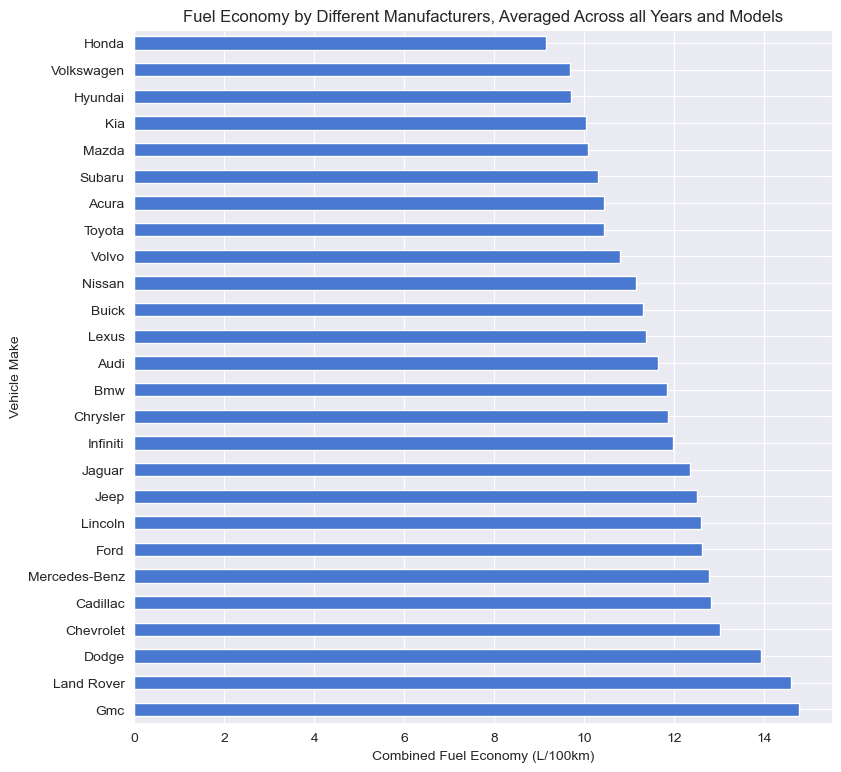

In [12]:
fuel_economy_by_year_and_make = full_dataset.pivot_table(index="model_year", 
                                                         columns="make", 
                                                         values="comb_lpkm", 
                                                         aggfunc="mean")

ax = fuel_economy_by_year_and_make.mean().sort_values(ascending=False).plot(kind="barh", figsize=(9, 9))
ax.set_ylabel("Vehicle Make")
ax.set_xlabel("Combined Fuel Economy (L/100km)")
ax.set_title("Fuel Economy by Different Manufacturers, Averaged Across all Years and Models")

The figure above shows the average combined fuel economy for each manufacturer included in this investigation. On average, Honda vehicles are the most efficient while GMC are the least. These results will be unsurprising to most, since Honda primarily manufactures sedans while GMC specializes in trucks and SUVs. 

It's evident then, that the vehicle type may play an important role in determining fuel economy. 

In [13]:
# how many of each make?
full_dataset["make"].value_counts()

Chevrolet        1941
Ford             1664
Bmw              1541
Mercedes-Benz    1305
Gmc              1152
Dodge            1065
Toyota           1046
Audi              874
Nissan            787
Volkswagen        766
Mazda             623
Hyundai           585
Honda             583
Jeep              571
Kia               555
Subaru            537
Volvo             527
Lexus             484
Cadillac          460
Chrysler          432
Jaguar            387
Infiniti          286
Buick             279
Acura             257
Lincoln           231
Land Rover        220
Name: make, dtype: int64

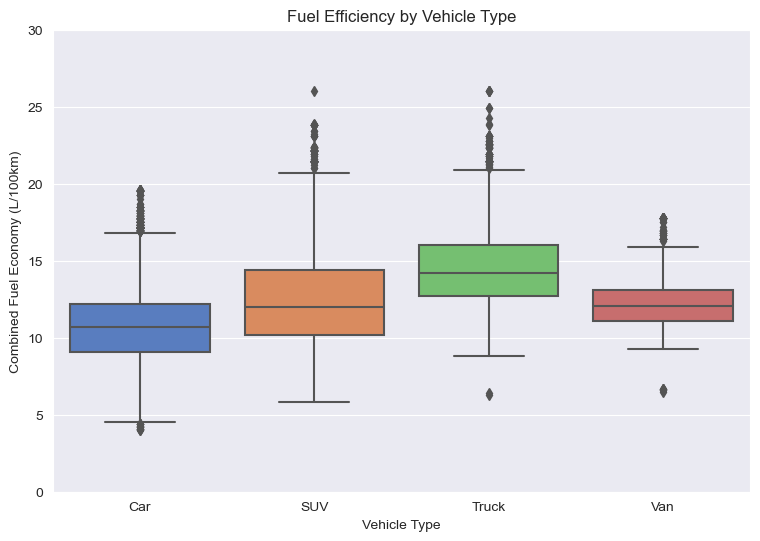

In [14]:
# fuel efficiency by vehicle type
ax = sns.boxplot(data=full_dataset, x="vehicle_class", y="comb_lpkm")
ax.set(xlabel="Vehicle Type", ylabel="Combined Fuel Economy (L/100km)", title="Fuel Efficiency by Vehicle Type")
ax.set_ylim(0, 30)
plt.gcf().set_size_inches(9, 6)

The figure above presents the average combined fuel economy for each vehicle class that was examined. It is evident that cars have the lowest average fuel economy, while SUVs and vans have similar means (although SUVs exhibit a greater degree of variation around it), and trucks have the highest average fuel economy.

In [15]:
# how many of each vehicle class?
full_dataset["vehicle_class"].value_counts()

Car      10544
SUV       5381
Truck     2803
Van        430
Name: vehicle_class, dtype: int64

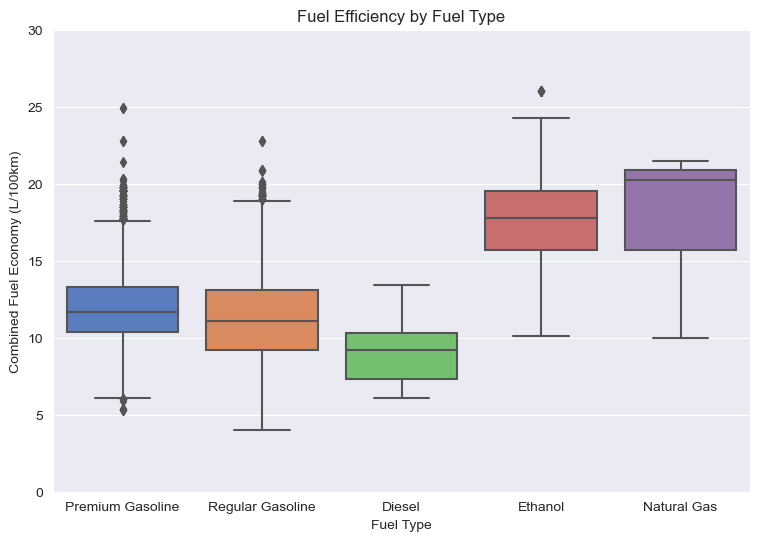

In [16]:
# fuel efficiency by fuel type
ax = sns.boxplot(data=full_dataset, x="fuel_type", y="comb_lpkm")
ax.set(xlabel="Fuel Type", ylabel="Combined Fuel Economy (L/100km)", title="Fuel Efficiency by Fuel Type")
ax.set_ylim(0, 30)
plt.gcf().set_size_inches(9, 6)

The figure above illustrates the combined fuel efficiency of different engine types. While the average is lowest for diesel vehicles, the lower range of both premium and regular gasoline vehicles appear more efficient than any observed diesel vehicle. That said, the upper range for both gasoline vehicles are far less efficient than any observed diesel vehicle. Ethanol and natural gas powered vehicles are evidently the least efficient in this dataset. 

In [17]:
# how many of each fuel type?
full_dataset["fuel_type"].value_counts()

Regular Gasoline    10641
Premium Gasoline     7193
Ethanol               917
Diesel                389
Natural Gas            18
Name: fuel_type, dtype: int64

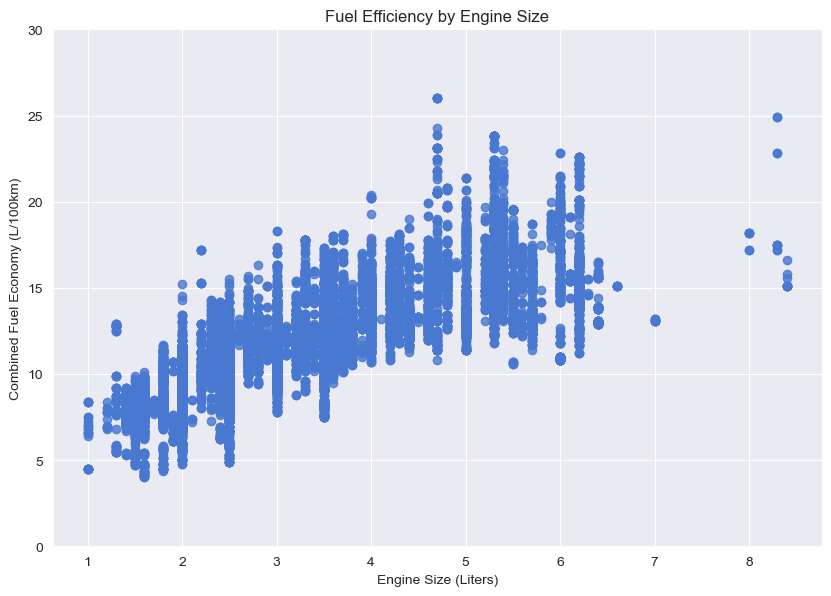

In [18]:
# fuel efficiency by engine size
ax = sns.lmplot(data=full_dataset, x="engine_size_L", y="comb_lpkm", fit_reg=False)
ax.set(xlabel="Engine Size (Liters)", ylabel="Combined Fuel Economy (L/100km)", 
       title="Fuel Efficiency by Engine Size")
ax.set(ylim=(0, 30))
plt.gcf().set_size_inches(9, 6)

The figure above shows a positive correlation between engine size and combined fuel economy. In simpler terms, it indicates that vehicles equipped with larger engines tend to be less fuel-efficient. 

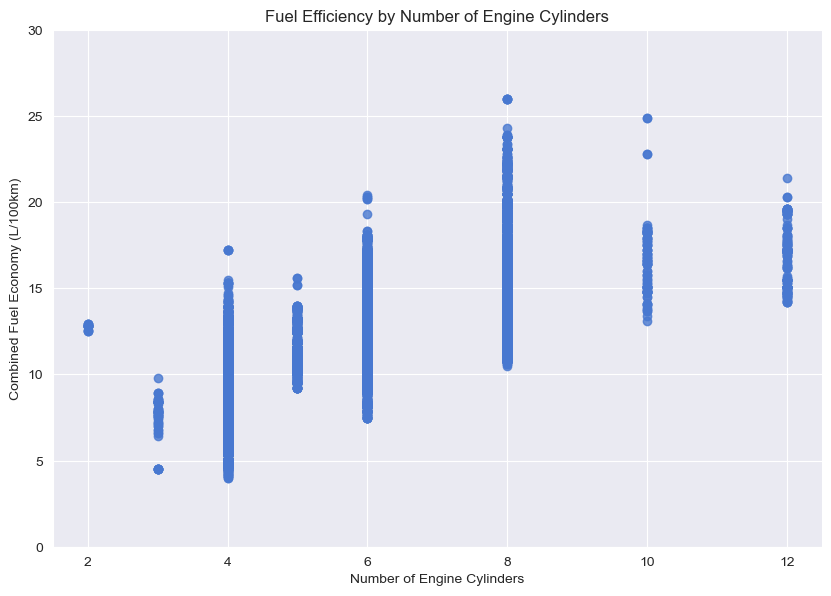

In [19]:
# fuel efficiency by engine cylinders
ax = sns.lmplot(data=full_dataset, x="cylinders", y="comb_lpkm", fit_reg=False)
ax.set(xlabel="Number of Engine Cylinders", ylabel="Combined Fuel Economy (L/100km)", 
       title="Fuel Efficiency by Number of Engine Cylinders")
ax.set(ylim=(0, 30))
ax.fig.set_size_inches(9, 6)

The figure above indicates a positive correlation between the number of engine cylinders and combined fuel economy for vehicles with more than 3 cylinders. Vehicles with 2 cylinders exhibit a higher than expected combined fuel economy; however, with a relatively small sample size of only 16 observations, it may be subject to sampling bias.

In [20]:
# how many of each number of engine cylinders?
full_dataset["cylinders"].value_counts()

4.0     6990
6.0     6853
8.0     4508
5.0      483
12.0     149
10.0     100
3.0       59
2.0       16
Name: cylinders, dtype: int64

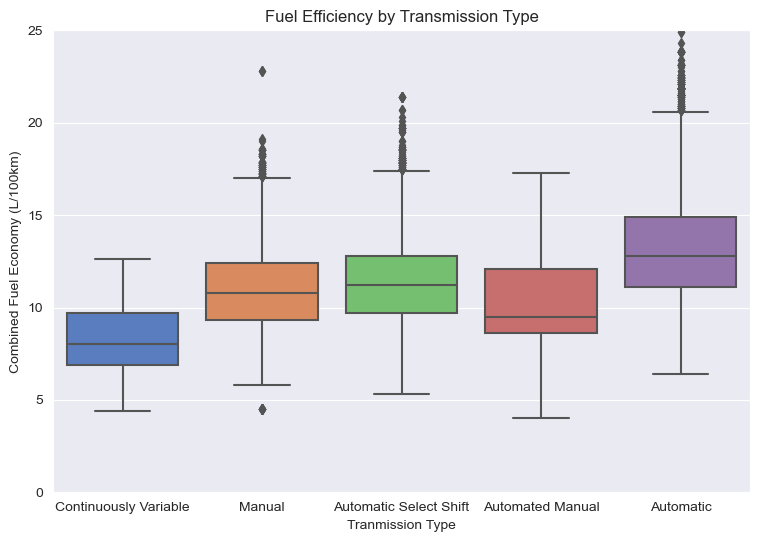

In [21]:
# fuel efficiency by transmission type
ax = sns.boxplot(data=full_dataset, x="transmission_type", y="comb_lpkm")
ax.set(xlabel="Tranmission Type", ylabel="Combined Fuel Economy (L/100km)", 
       title="Fuel Efficiency by Transmission Type")
ax.set(ylim=(0, 25))
plt.gcf().set_size_inches(9, 6)

In [22]:
# how many of each type of transmission?
full_dataset["transmission_type"].value_counts()

Automatic                 7459
Automatic Select Shift    6149
Manual                    3762
Continuously Variable     1138
Automated Manual           650
Name: transmission_type, dtype: int64

Text(0.5, 0, 'Figure X: ')

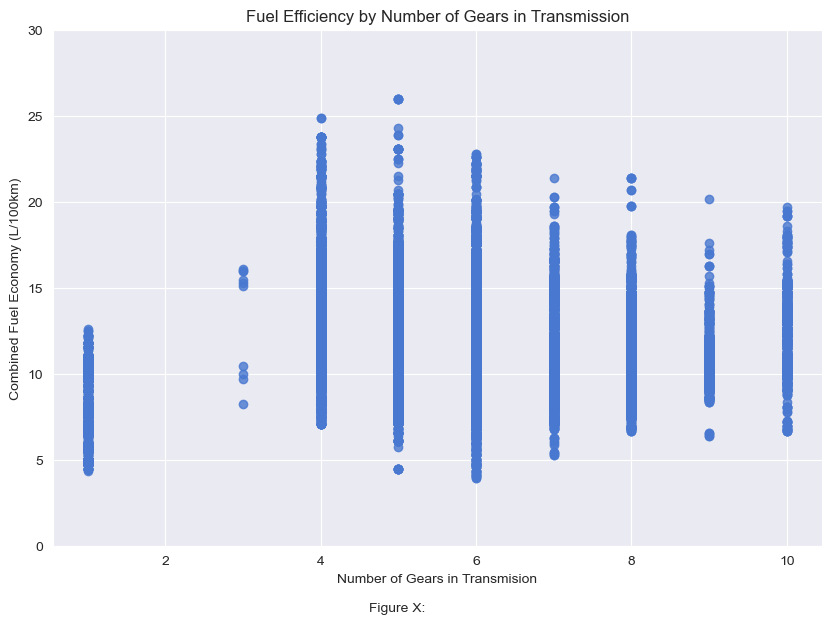

In [23]:
# fuel efficiency by transmission gears
ax = sns.lmplot(data=full_dataset, x="transmission_gears", y="comb_lpkm", fit_reg=False)
ax.set(xlabel="Number of Gears in Transmision", ylabel="Combined Fuel Economy (L/100km)", 
       title="Fuel Efficiency by Number of Gears in Transmission")
ax.set(ylim=(0, 30))
plt.gcf().set_size_inches(9, 6)

In [24]:
# how many of each number of transmission gears?
full_dataset["transmission_gears"].value_counts()

6     6571
5     3787
4     2751
8     2541
7     1342
1      775
9      700
10     681
3       10
Name: transmission_gears, dtype: int64

### b. Temporal Effects

Text(0.5, 0, 'Figure X: ')

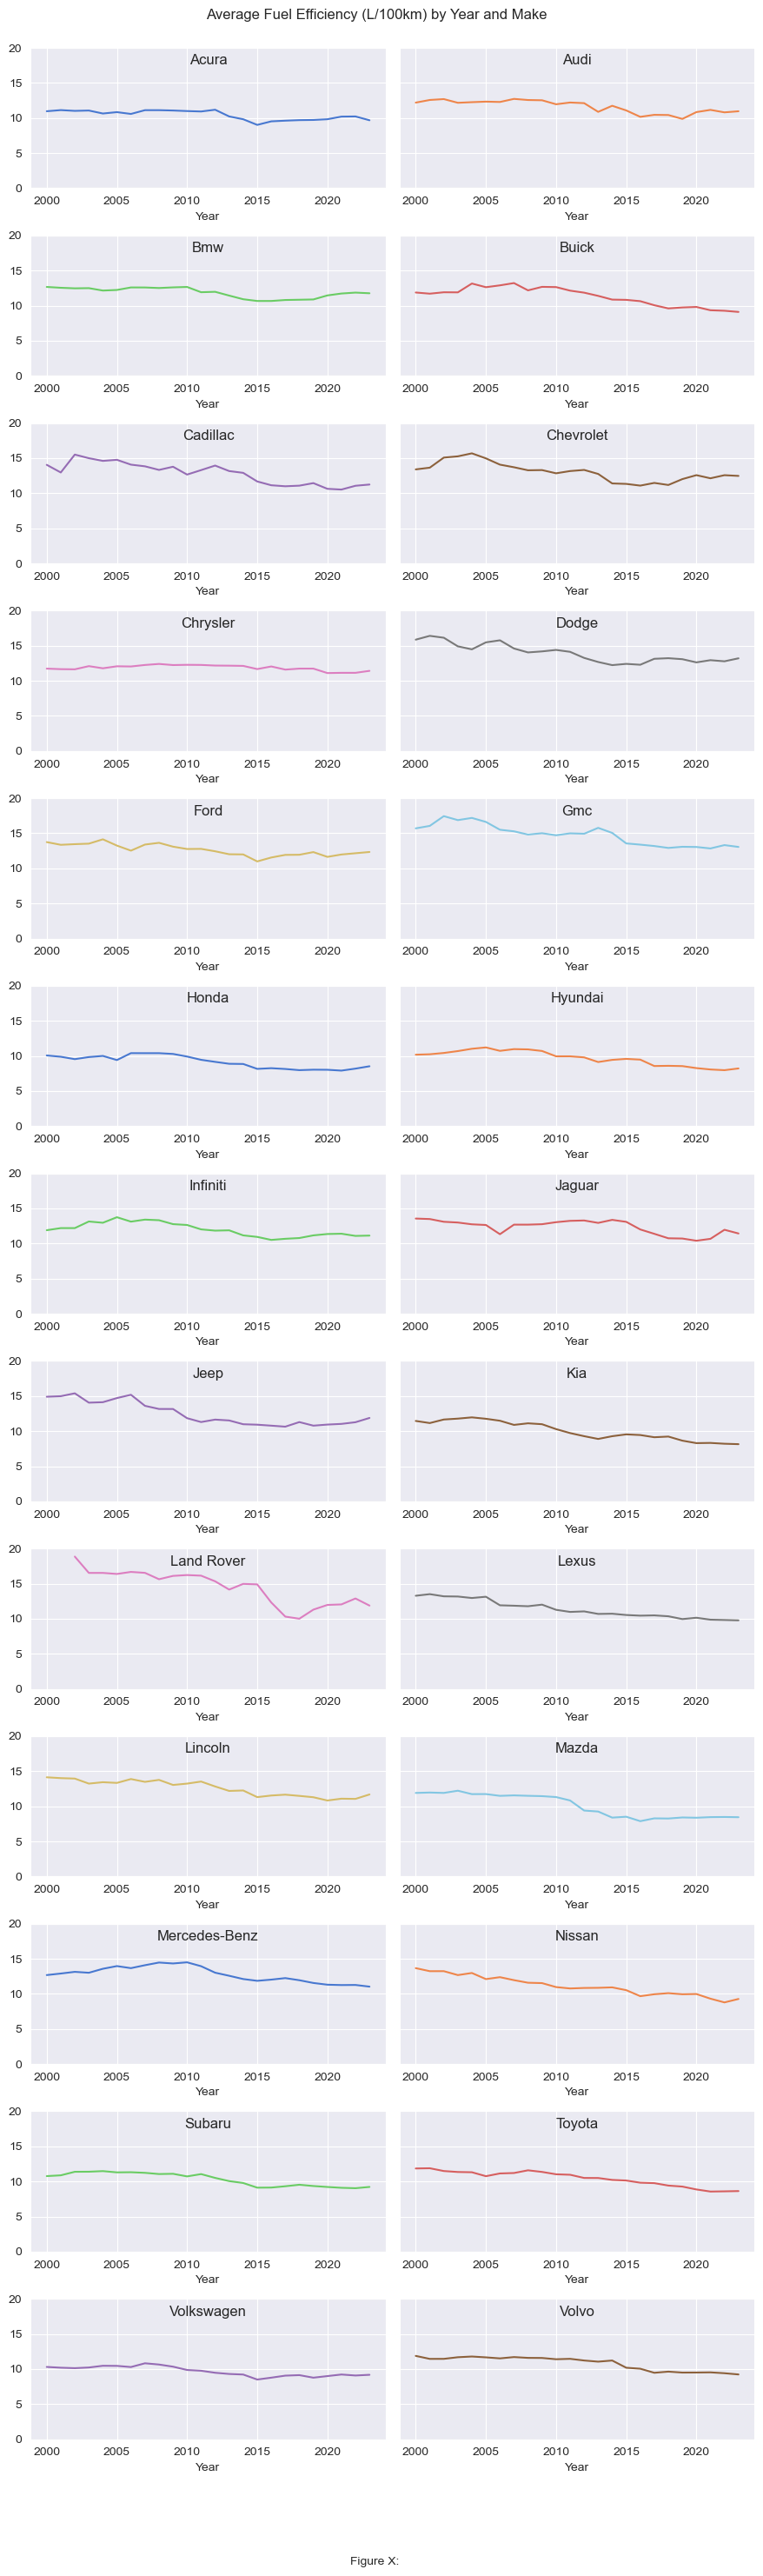

In [25]:
# exploring interaction between year and make
fuel_economy_by_year_and_make = full_dataset.pivot_table(index="model_year", 
                                                         columns="make", 
                                                         values="comb_lpkm", 
                                                         aggfunc="mean")

axs = fuel_economy_by_year_and_make.plot.line(
    figsize=(9, 30), subplots=True, legend=False, sharex=False,
    sharey=True, layout=(13, 2), xlabel="Year"
)

axs[0,0].get_figure().tight_layout(rect=[0, 0.03, 1, 0.97])
axs[0,0].get_figure().suptitle('Average Fuel Efficiency (L/100km) by Year and Make')
axs = axs.flatten()
titles = fuel_economy_by_year_and_make.columns
i = 0
for ax in axs:
    title = titles[i]
    ax.set_title(title, y=1.0, pad=-14)
    ax.set_ylim(0, 20)
    i += 1

Text(0.5, 0, 'Figure X: ')

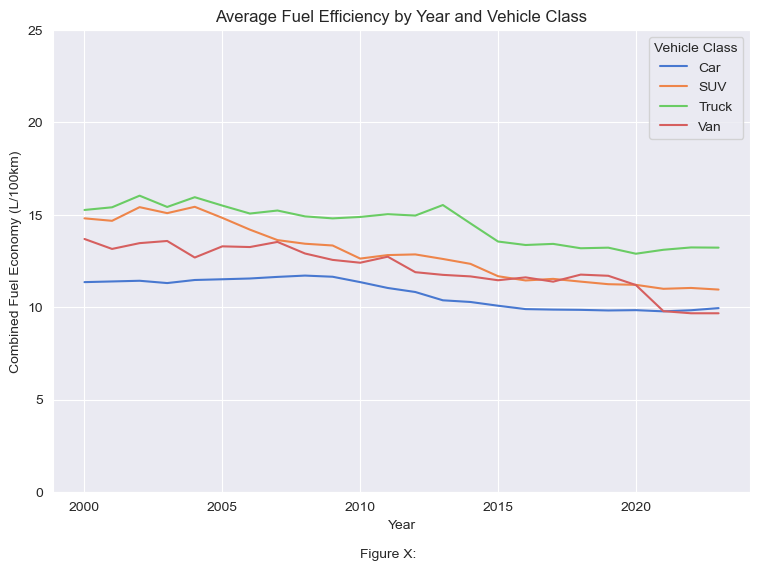

In [26]:
fuel_economy_by_year_and_vehicle_type = full_dataset.pivot_table(index="model_year", 
                                                                 columns="vehicle_class", 
                                                                 values="comb_lpkm", 
                                                                 aggfunc="mean")

ax = fuel_economy_by_year_and_vehicle_type.plot.line()
ax.set_xlabel("Year")
ax.set_ylabel("Combined Fuel Economy (L/100km)")
ax.set_ylim(0, 25)
ax.set_title("Average Fuel Efficiency by Year and Vehicle Class")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title="Vehicle Class", loc='upper right')
plt.gcf().set_size_inches(9, 6)

Text(0.5, 0, 'Figure X: ')

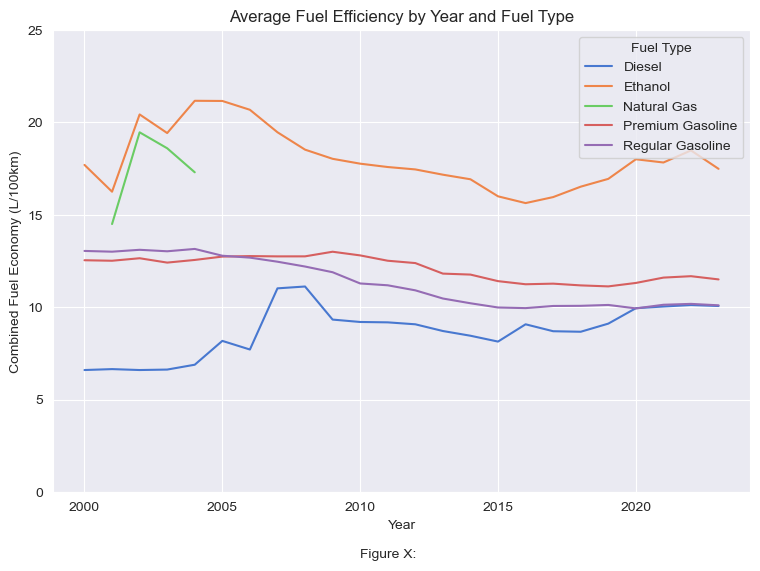

In [27]:
fuel_economy_by_year_and_fuel_type = full_dataset.pivot_table(index="model_year", 
                                                              columns="fuel_type", 
                                                              values="comb_lpkm", 
                                                              aggfunc="mean")

ax = fuel_economy_by_year_and_fuel_type.plot.line()
ax.set_xlabel("Year")
ax.set_ylabel("Combined Fuel Economy (L/100km)")
ax.set_ylim(0, 25)
ax.set_title("Average Fuel Efficiency by Year and Fuel Type")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title="Fuel Type", loc='upper right')
plt.gcf().set_size_inches(9, 6)

Text(0.5, 0, 'Figure X: ')

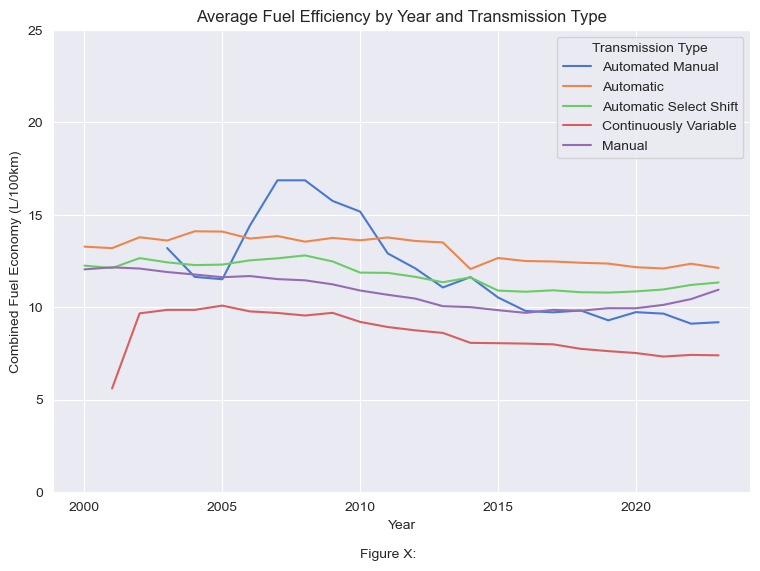

In [28]:
fuel_economy_by_year_and_transmission_type = full_dataset.pivot_table(index="model_year", 
                                                                      columns="transmission_type", 
                                                                      values="comb_lpkm", 
                                                                      aggfunc="mean")

ax = fuel_economy_by_year_and_transmission_type.plot.line()
ax.set_xlabel("Year")
ax.set_ylabel("Combined Fuel Economy (L/100km)")
ax.set_ylim(0, 25)
ax.set_title("Average Fuel Efficiency by Year and Transmission Type")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title="Transmission Type", loc='upper right')
plt.gcf().set_size_inches(9, 6)

### c. Exploring Correlations

In [29]:
# exploring correlations between continous variables
corr_matrix = full_dataset.drop(["comb_lpkm"], axis=1).corr()
print(corr_matrix)

                    model_year  engine_size_L  cylinders  transmission_gears
model_year            1.000000      -0.090164  -0.113865            0.568770
engine_size_L        -0.090164       1.000000   0.915535            0.084226
cylinders            -0.113865       0.915535   1.000000            0.118175
transmission_gears    0.568770       0.084226   0.118175            1.000000


Text(0.5, 0, 'Figure X: ')

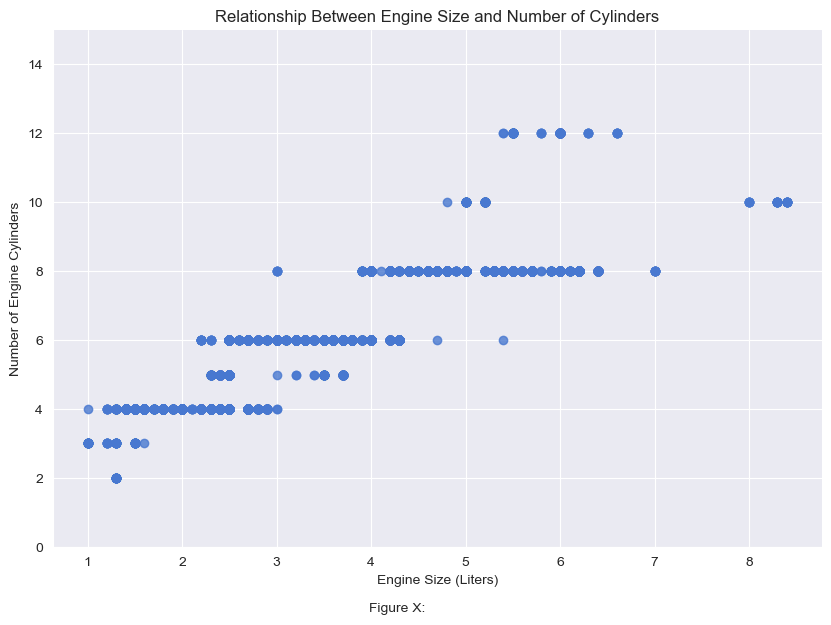

In [30]:
# exploring correlation between engine size and engine cylinders
ax = sns.lmplot(data=full_dataset, x="engine_size_L", y="cylinders", fit_reg=False)
ax.set(xlabel="Engine Size (Liters)", ylabel="Number of Engine Cylinders", 
       title="Relationship Between Engine Size and Number of Cylinders")
ax.set(ylim=(0, 15))
ax.fig.set_size_inches(9, 6)

### d. General Findings

In [31]:
# finding the most efficient vehicle
min_ID = full_dataset["comb_lpkm"].idxmin()
most_efficient_comb_lpkm = full_dataset["comb_lpkm"][min_ID]
most_efficient_year = full_dataset["model_year"][min_ID]
most_efficient_make = full_dataset["make"][min_ID]
most_efficient_model = full_dataset["model"][min_ID]
print(f"The {most_efficient_make} {most_efficient_model} from {most_efficient_year} " + 
      "was the most efficient vehicle at {most_efficient_comb_lpkm} L/100km")

# finding the least efficient vehicle
max_ID = full_dataset["comb_lpkm"].idxmax()
least_efficient_comb_lpkm = full_dataset["comb_lpkm"][max_ID]
least_efficient_year = full_dataset["model_year"][max_ID]
least_efficient_make = full_dataset["make"][max_ID]
least_efficient_model = full_dataset["model"][max_ID]
print(f"The {least_efficient_make} {least_efficient_model} from {least_efficient_year} " + 
      "was the least efficient vehicle at {least_efficient_comb_lpkm} L/100km")

The Hyundai IONIQ Blue from 2022 was the most efficient vehicle at {most_efficient_comb_lpkm} L/100km
The Dodge RAM 1500 4X4 FFV from 2005 was the least efficient vehicle at {least_efficient_comb_lpkm} L/100km


In [32]:
# exploring which companies made the most efficient vehicles in each year, based on vehicle class
fuel_economy_by_year_make_and_vehicle_type = full_dataset.pivot_table(index=["model_year", "make"], 
                                                                      columns="vehicle_class", 
                                                                      values="comb_lpkm", 
                                                                      aggfunc="mean")

fuel_economy_by_year_make_and_vehicle_type.reset_index(["model_year"], inplace=True)
fuel_economy_by_year_make_and_vehicle_type

by_year = fuel_economy_by_year_make_and_vehicle_type.groupby("model_year")
by_year.idxmin()

vehicle_class,Car,SUV,Truck,Van
model_year,,,,
2000,Honda,Subaru,Nissan,Chevrolet
2001,Honda,Subaru,Toyota,Chevrolet
2002,Honda,Subaru,Mazda,Chevrolet
2003,Honda,Subaru,Toyota,Chevrolet
2004,Honda,Mazda,Mazda,Dodge
2005,Honda,Subaru,Mazda,Honda
2006,Honda,Subaru,Mazda,Honda
2007,Toyota,Subaru,Mazda,Toyota
2008,Toyota,Subaru,Mazda,Mazda


Text(0.5, 0, 'Figure X: ')

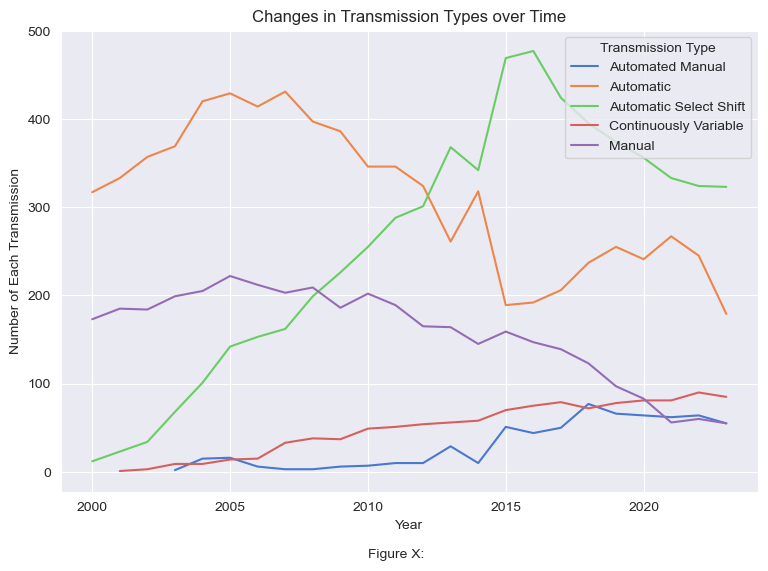

In [33]:
# exploring changes in transmissions over time
transmissions_by_year = full_dataset.pivot_table(index="model_year", 
                                                 columns="transmission_type", 
                                                 values="make", 
                                                 aggfunc="count")

ax = transmissions_by_year.plot()
ax.set_xlabel("Year")
ax.set_ylabel("Number of Each Transmission")
ax.set_title("Changes in Transmission Types over Time")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title="Transmission Type", loc='upper right')
plt.gcf().set_size_inches(9, 6)

## 3. Fitting Models

### 3a. No Interactions

In [34]:
# create X and y training and testing datasets
y, X = patsy.dmatrices("comb_lpkm ~ model_year + C(make) + C(vehicle_class) + " +
                       "C(fuel_type) + engine_size_L + cylinders + C(transmission_type) + " +
                        "transmission_gears", full_dataset, return_type='matrix')
train = full_dataset.sample(frac = 0.75,random_state = 42) 
test = full_dataset.drop(train.index)
y_train = y[train.index]
X_train = X[train.index]
y_test = y[test.index]
X_test = X[test.index]

In [35]:
# fit a linear regression model
fuel_efficiency_lr_model = linear_model.LinearRegression()
fuel_efficiency_lr_model.fit(X_train, y_train)

mse_train = metrics.mean_squared_error(y_train, fuel_efficiency_lr_model.predict(X_train))
mse_test = metrics.mean_squared_error(y_test, fuel_efficiency_lr_model.predict(X_test))

print(f"The MSE on the training data is: {mse_train} and the MSE on the testing data is {mse_test}")

The MSE on the training data is: 1.1465040941968903 and the MSE on the testing data is 1.1911687444077146


In [36]:
# fit a lasso regression model
fuel_efficiency_lasso_model = linear_model.Lasso()
fuel_efficiency_lasso_model.fit(X_train, y_train)

mse_train = metrics.mean_squared_error(y_train, fuel_efficiency_lasso_model.predict(X_train))
mse_test = metrics.mean_squared_error(y_test, fuel_efficiency_lasso_model.predict(X_test))

print(f"The MSE on the training data is: {mse_train} and the MSE on the testing data is {mse_test}")

The MSE on the training data is: 3.567729185196054 and the MSE on the testing data is 3.52279011595829


In [37]:
param_names = X.design_info.column_names
lasso_coefs = pd.Series(dict(zip(param_names, fuel_efficiency_lasso_model.coef_)))
lr_coefs = pd.Series(dict(zip(param_names, fuel_efficiency_lr_model.coef_[0])))
coefs = pd.DataFrame(dict(lasso=lasso_coefs, linreg=lr_coefs))
coefs

,lasso,linreg
Intercept,0.000000,-5.313773e-15
C(make)[T.Audi],-0.000000,8.505457e-01
C(make)[T.Bmw],-0.000000,3.797805e-01
C(make)[T.Buick],-0.000000,3.793529e-01
C(make)[T.Cadillac],0.000000,8.185901e-01
C(make)[T.Chevrolet],0.000000,4.888878e-02
C(make)[T.Chrysler],-0.000000,4.315291e-01
C(make)[T.Dodge],0.000000,4.609029e-01
C(make)[T.Ford],0.000000,5.692869e-01
C(make)[T.Gmc],0.000000,2.256725e-01


Text(-0.8334944602183618, 8.859843505238617, '5 fold cross-validation')

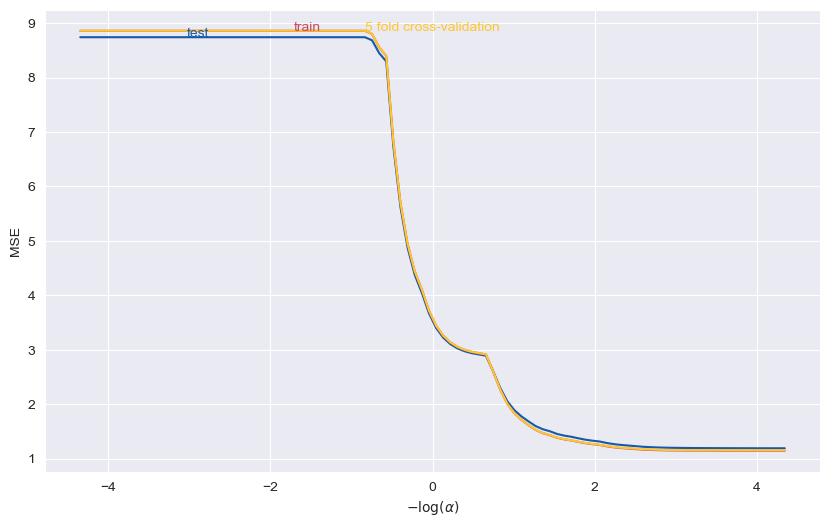

In [38]:
from sklearn.model_selection import cross_val_score

# number of cross-validation folds
k = 5

# create a function for calculating mses
def fit_and_report_mses(mod, X_train, X_test, y_train, y_test):
    mod.fit(X_train, y_train)
    return dict(
        mse_train=metrics.mean_squared_error(y_train, mod.predict(X_train)),
        mse_test=metrics.mean_squared_error(y_test, mod.predict(X_test))
    )

# create the alphas and mse values for different alphas
alphas = np.exp(np.linspace(10, -10, 100))
mse = pd.DataFrame([fit_and_report_mses(linear_model.Lasso(alpha=alpha, max_iter=50000),
                           X_train, X_test, y_train, y_test)
                    for alpha in alphas])
mse["log_alpha"] = -np.log10(alphas)
mse["cv"] = [-np.mean(cross_val_score(linear_model.Lasso(alpha=alpha, max_iter=50000),
                                  X_train, y_train, cv=k, scoring='neg_mean_squared_error'))
          for alpha in alphas]

# create the plot
colors = ['#165aa7', '#cb495c', '#fec630']
fig, ax = plt.subplots(figsize=(10,6))
mse.plot(x="log_alpha", y="mse_test", c=colors[0], ax=ax)
mse.plot(x="log_alpha", y="mse_train", c=colors[1], ax=ax)
mse.plot(x="log_alpha", y="cv", c=colors[2], ax=ax)
ax.set_xlabel(r"$-\log(\alpha)$")
ax.set_ylabel("MSE")
ax.get_legend().remove()
ax.annotate("test",(mse.log_alpha[15], mse.mse_test[15]),color=colors[0])
ax.annotate("train",(mse.log_alpha[30], mse.mse_train[30]),color=colors[1])
ax.annotate(f"{k} fold cross-validation", (mse.log_alpha[40], mse.cv[40]), color=colors[2])

In [39]:
# fit an updated lasso regression model with an alpha to optimize MSE
fuel_efficiency_lasso_model = linear_model.Lasso(alpha=0.01)
fuel_efficiency_lasso_model.fit(X_train, y_train)

mse_train = metrics.mean_squared_error(y_train, fuel_efficiency_lasso_model.predict(X_train))
mse_test = metrics.mean_squared_error(y_test, fuel_efficiency_lasso_model.predict(X_test))

print(f"The MSE on the training data is: {mse_train} and the MSE on the testing data is {mse_test}")

The MSE on the training data is: 1.2618531275813012 and the MSE on the testing data is 1.3255729486588832


In [40]:
param_names = X.design_info.column_names
lasso_coefs = pd.Series(dict(zip(param_names, fuel_efficiency_lasso_model.coef_)))
lr_coefs = pd.Series(dict(zip(param_names, fuel_efficiency_lr_model.coef_[0])))
coefs = pd.DataFrame(dict(lasso=lasso_coefs, linreg=lr_coefs))
coefs

,lasso,linreg
Intercept,0.000000,-5.313773e-15
C(make)[T.Audi],0.138993,8.505457e-01
C(make)[T.Bmw],-0.000000,3.797805e-01
C(make)[T.Buick],-0.000000,3.793529e-01
C(make)[T.Cadillac],0.000000,8.185901e-01
C(make)[T.Chevrolet],-0.219013,4.888878e-02
C(make)[T.Chrysler],0.000000,4.315291e-01
C(make)[T.Dodge],0.000000,4.609029e-01
C(make)[T.Ford],0.110154,5.692869e-01
C(make)[T.Gmc],-0.000000,2.256725e-01


In [41]:
# fitting a regression tree
fuel_efficiency_fitted_tree = tree.DecisionTreeRegressor(max_depth=20, random_state=123).fit(X_train,y_train)
mse_train = metrics.mean_squared_error(y_train, fuel_efficiency_fitted_tree.predict(X_train))
mse_test = metrics.mean_squared_error(y_test, fuel_efficiency_fitted_tree.predict(X_test))
print(f"The MSE on the training data is: {mse_train} and the MSE on the testing data is {mse_test}")

The MSE on the training data is: 0.20124997511956674 and the MSE on the testing data is 0.5385431589761258


### 3b. Interactions with year

In [42]:
# create X and y training and testing datasets
y, X = patsy.dmatrices("comb_lpkm ~ model_year*(C(make) + C(vehicle_class) + " +
                       "C(fuel_type) + engine_size_L + cylinders + C(transmission_type) + " +
                        "transmission_gears)", full_dataset, return_type='matrix')
train = full_dataset.sample(frac = 0.75,random_state = 42) 
test = full_dataset.drop(train.index)
y_train = y[train.index]
X_train = X[train.index]
y_test = y[test.index]
X_test = X[test.index]

In [43]:
# fit a linear regression model
fuel_efficiency_interaction_lr_model = linear_model.LinearRegression()
fuel_efficiency_interaction_lr_model.fit(X_train, y_train)

mse_train = metrics.mean_squared_error(y_train, fuel_efficiency_interaction_lr_model.predict(X_train))
mse_test = metrics.mean_squared_error(y_test, fuel_efficiency_interaction_lr_model.predict(X_test))

print(f"The MSE on the training data is: {mse_train} and the MSE on the testing data is {mse_test}")

The MSE on the training data is: 1.0164888205677867 and the MSE on the testing data is 1.0574064880915504


In [44]:
# fit a lasso regression model
fuel_efficiency_interaction_lasso_model = linear_model.Lasso()
fuel_efficiency_interaction_lasso_model.fit(X_train, y_train)

mse_train = metrics.mean_squared_error(y_train, fuel_efficiency_interaction_lasso_model.predict(X_train))
mse_test = metrics.mean_squared_error(y_test, fuel_efficiency_interaction_lasso_model.predict(X_test))

print(f"The MSE on the training data is: {mse_train} and the MSE on the testing data is {mse_test}")

The MSE on the training data is: 1.206336775451524 and the MSE on the testing data is 1.2563576460301875


In [45]:
param_names = X.design_info.column_names
lasso_coefs = pd.Series(dict(zip(param_names, fuel_efficiency_interaction_lasso_model.coef_)))
lr_coefs = pd.Series(dict(zip(param_names, fuel_efficiency_interaction_lr_model.coef_[0])))
coefs = pd.DataFrame(dict(lasso=lasso_coefs, linreg=lr_coefs))
coefs

,lasso,linreg
Intercept,0.000000e+00,2.575492e-07
C(make)[T.Audi],0.000000e+00,2.924054e+01
C(make)[T.Bmw],0.000000e+00,-4.111535e+01
C(make)[T.Buick],-0.000000e+00,-2.025076e+02
C(make)[T.Cadillac],0.000000e+00,-8.341092e+01
C(make)[T.Chevrolet],-0.000000e+00,-1.648682e+02
C(make)[T.Chrysler],0.000000e+00,-6.009421e+01
C(make)[T.Dodge],0.000000e+00,-6.285815e+01
C(make)[T.Ford],0.000000e+00,-1.928469e+02
C(make)[T.Gmc],-0.000000e+00,-1.072576e+02


In [46]:
# fitting a regression tree
fuel_efficiency_interaction_fitted_tree = tree.DecisionTreeRegressor(max_depth=20, 
                                                                     random_state=123).fit(X_train,y_train)
mse_train = metrics.mean_squared_error(y_train, fuel_efficiency_interaction_fitted_tree.predict(X_train))
mse_test = metrics.mean_squared_error(y_test, fuel_efficiency_interaction_fitted_tree.predict(X_test))
print(f"The MSE on the training data is: {mse_train} and the MSE on the testing data is {mse_test}")

The MSE on the training data is: 0.20924276375155768 and the MSE on the testing data is 0.5555888399566201


### 3c. Testing the Models

In [47]:
full_dataset.head()

,model_year,make,model,vehicle_class,fuel_type,engine_size_L,cylinders,transmission_type,transmission_gears,comb_lpkm
0,2023,Acura,Integra,Car,Premium Gasoline,1.5,4.0,Continuously Variable,7,7.2
1,2023,Acura,Integra A-SPEC,Car,Premium Gasoline,1.5,4.0,Continuously Variable,7,7.4
2,2023,Acura,Integra A-SPEC,Car,Premium Gasoline,1.5,4.0,Manual,6,7.8
3,2023,Acura,MDX SH-AWD,SUV,Premium Gasoline,3.5,6.0,Automatic Select Shift,10,11.2
4,2023,Acura,MDX SH-AWD Type S,SUV,Premium Gasoline,3.0,6.0,Automatic Select Shift,10,12.4


Let's take a look at some upcoming vehicles:
- 2024 Ford F-150 (a truck) with a 3.5L V6 gasoline engine and 10 speed automatic transmission, that gets an estimated 11.7 L/100km
- 2024 Honda Civic (a car) with a 2.0L 4-Cylinder gasoline engine and continuously variable transmission, that gets an estimated 6.5 L/100km
- 2024 Mazda CX-90 (a SUV) with a 3.3L V6 premium gasoline engine and 8 speed automatic transmission, that gets an estimated 9.4 L/100km
- 2024 Kia Carnival (a Minivan) with a 3.5L V6 gasoline engine and 8 speed automatic transmission, that gets an estimated 10.7 L/100km

Most 2024 models aren't officially published, so this data was obtained from the following sources
- https://www.edmunds.com/ford/f-150/2024/#:~:text=EPA%2Destimated%20fuel%20economy%20is,V8%2Dequipped%20Silverado%20or%20Ram
- https://www.caranddriver.com/honda/civic
- https://www.caranddriver.com/news/a42789780/2024-mazda-cx-90-power-mpg-specs/
- https://driving.ca/kia/carnival/

In [48]:
# creating the dataset
data = {"model_year": [2024, 2024, 2024, 2024],
                 "make": ["Ford", "Honda", "Mazda", "Kia"],
                 "model": ["F-150", "Civic", "CX-90", "Carnival"],
                 "vehicle_class": ["Truck", "Car", "SUV", "Van"],
                 "fuel_type": ["Regular Gasoline", "Regular Gasoline", "Premium Gasoline", "Regular Gasoline"],
                 "engine_size_L": [3.5, 2, 3.3, 3.5],
                 "cylinders": [6.0, 4.0, 6.0, 6.0],
                 "transmission_type": ["Automatic", "Continuously Variable", "Automatic", "Automatic"],
                 "transmission_gears": [10, 1, 8, 8],
                 "comb_lpkm": [11.7, 6.5, 9.4, 10.7]}

vehicles_to_predict = pd.DataFrame(data)
full_dataset_with_predictions = pd.concat([full_dataset, vehicles_to_predict])
full_dataset_with_predictions.reset_index(drop=True,inplace=True)
full_dataset_with_predictions.loc[full_dataset_with_predictions.index[-4]:full_dataset_with_predictions.index[-1],:]

,model_year,make,model,vehicle_class,fuel_type,engine_size_L,cylinders,transmission_type,transmission_gears,comb_lpkm
19158,2024,Ford,F-150,Truck,Regular Gasoline,3.5,6.0,Automatic,10,11.7
19159,2024,Honda,Civic,Car,Regular Gasoline,2.0,4.0,Continuously Variable,1,6.5
19160,2024,Mazda,CX-90,SUV,Premium Gasoline,3.3,6.0,Automatic,8,9.4
19161,2024,Kia,Carnival,Van,Regular Gasoline,3.5,6.0,Automatic,8,10.7


In [49]:
y, X = patsy.dmatrices("comb_lpkm ~ model_year + C(make) + C(vehicle_class) + " +
                       "C(fuel_type) + engine_size_L + cylinders + C(transmission_type) + " +
                        "transmission_gears", full_dataset_with_predictions, return_type='matrix')
test_vehicles = X[-4:,:]
predicted_efficiency = fuel_efficiency_lasso_model.predict(test_vehicles)
actual_efficiency = y[-4:]
actual_efficiency = actual_efficiency.flatten()
percent_error = abs(predicted_efficiency-actual_efficiency)/actual_efficiency*100
vehicle_names = ("2024 Ford F150", "2024 Honda Civic", "2024 Mazda CX-90", "2024 Kia Carnival")
predicted = pd.Series(dict(zip(vehicle_names, predicted_efficiency)))
actual = pd.Series(dict(zip(vehicle_names, actual_efficiency)))
difference = pd.Series(dict(zip(vehicle_names, percent_error)))
result = pd.DataFrame(dict(predicted_efficiency=predicted, actual_efficiency=actual, percent_difference=difference))
result

,predicted_efficiency,actual_efficiency,percent_difference
2024 Ford F150,11.693242,11.7,0.057763
2024 Honda Civic,6.350384,6.5,2.301786
2024 Mazda CX-90,11.643362,9.4,23.865553
2024 Kia Carnival,10.294702,10.7,3.787828


# Improvement by company

In [50]:
#Ford
ford_dataset = full_dataset.loc[full_dataset['make'] == 'Ford']
ford_dataset = ford_dataset[['model_year', 'vehicle_class','comb_lpkm']]
ford_dataset = ford_dataset.set_index("model_year").sort_index()
ford_dataset = ford_dataset.pivot_table(index="model_year", columns="vehicle_class", 
                                            values="comb_lpkm", aggfunc="mean")
ford_dataset

vehicle_class,Car,SUV,Truck,Van
model_year,,,,
2000,11.240000,15.741667,15.216667,13.500
2001,11.254545,14.400000,15.045455,13.000
2002,11.190909,14.630000,15.033333,13.300
2003,11.646154,14.320000,15.096154,13.300
2004,11.585185,15.150000,16.400000,13.900
2005,11.958333,13.038462,15.094444,13.500
2006,11.205556,12.233333,14.378571,13.800
2007,12.160870,12.023077,15.477273,13.600
2008,12.429412,12.008333,15.312500,NaN


In [51]:
#adding financials 
ford_dataset['R&D Expense'] = ford_dataset.index.map(ford_rnd)
ford_dataset

NameError: name 'ford_rnd' is not defined

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

ford_dataset[['Car', 'SUV', 'Truck']].plot.line(ax=ax)
ax.set_xlabel("Year")
ax.set_ylabel("Combined Fuel Economy (L/100km)")
ax.set_ylim(5, 20)
ax.set_title("Ford Average Fuel Efficiency by Year and Combined Vehicle Class, ")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title="Vehicle Class", loc='lower left')

ax_rnd = ax.twinx()
ax_rnd = ford_dataset['R&D Expense'].plot.line(color='red', alpha=0.5)
ax_rnd.set_ylabel('R&D Expense', color='r')
ax_rnd.tick_params(colors='r')
handles, labels = ax_rnd.get_legend_handles_labels()
ax_rnd.legend(handles, labels, loc='lower right') 
ax_rnd.annotate("The Great Financial Crisis hits \n the american auto industry", xy=(230, 35), 
                xycoords='axes points', xytext=(500, 50), annotation_clip=False, 
                horizontalalignment="right", arrowprops={
                    "arrowstyle": "-|>", "connectionstyle": "angle3,angleA=0,angleB=10", "color": "black"}, 
                fontsize=10)

# Retrieving RnD Expense

In [ ]:
! pip install tabula-py

In [ ]:
import tabula
from datetime import datetime

In [ ]:
#scraping earnings data

#feed in URL and extract all tables from the pdf
url = "https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_9_2007_consolidated.pdf"
all_dfs = tabula.read_pdf(url, pages='all', multiple_tables=True)
#print(all_dfs)

In [ ]:
#find the table which contains the R&D expenses
for df in all_dfs:
    if ('R&D Expenses (billions of yen)' in df.values) or (
        'Research & Development (billions of yen)' in df.values):
        RnD_df = df
        RnD_df.reset_index(drop=True, inplace=True)
        break
        
RnD_df = RnD_df.set_index(RnD_df.columns[0])
#print(RnD_df)

In [ ]:
#get full-year cols
#most pdfs have a col for 12 months/12 mos. ended so it's easy. For ones that dont, just going to look for 
#high nums which is a bit of a crappy workaround but good enough for now. Might want to find a better way later
#though since this won't be generalizable going way back 
check_format = RnD_df.loc[:, RnD_df.apply(lambda x: ('12 months' in x.values) or ('12 mos. ended' in x.values))]
if len(check_format.columns) != 0:
    filtered_RnD_df = RnD_df.loc[:, RnD_df.apply(lambda x: ('12 months' in x.values) or ('12 mos. ended' in x.values))]
else:
    try: 
        RnD_df = RnD_df.loc[:,RnD_df.loc["R&D Expense (billions of yen)"].notna()]
        filtered_RnD_df = RnD_df.iloc[:, [4, 9]]
    except KeyError: 
        try: 
            RnD_df = RnD_df.loc[:,RnD_df.loc["Research & Development (billions of yen)"].notna()]
            filtered_RnD_df = RnD_df.iloc[:, [4, 9]]
        except: print("No col found")

#remove the forecast col if present, sometimes it seems to be the column title and sometimes just in one of
#.  the first rows. Removing both just in case. 
forecast_col = filtered_RnD_df.applymap(lambda x: "Forecast" in str(x)).any()
filtered_RnD_df = filtered_RnD_df.drop(columns=filtered_RnD_df.columns[forecast_col])
if "Forecast" in filtered_RnD_df:
    filtered_RnD_df = filtered_RnD_df.drop(["Forecast"], axis=1)

#print(filtered_RnD_df)

In [ ]:
filtered_RnD_df = filtered_RnD_df.dropna(how='all')

fiscal_yr = []

filtered_RnD_df = filtered_RnD_df.dropna()

old_dates = filtered_RnD_df.loc[filtered_RnD_df.iloc[:,1].str.contains("FY")].values.tolist()
if len(old_dates) != 0:
    for date in old_dates[0]:
        year = int(date[2:6])
        fiscal_yr.append(year)
elif len(filtered_RnD_df.loc[filtered_RnD_df.iloc[:,1].str.contains("'")].values.tolist()) != 0:
    date_values = filtered_RnD_df.loc[filtered_RnD_df.iloc[:,0].str.contains("'")].values
    for date_range in date_values[0].tolist():
        end_date_yr = date_range[8:10]
        year = int(end_date_yr) + 2000
        fiscal_yr.append(year)
else:
    try:
        date1 = int(all_dfs[0].iloc[:,0][6][2:])    #int(filtered_RnD_df.iloc[0,0][4:8])
    except ValueError:
        date1 = int(all_dfs[0].columns[2][2:])
    date2 = date1 + 1
    fiscal_yr.append(date1)
    fiscal_yr.append(date2)
        
filtered_RnD_df.columns = fiscal_yr

In [ ]:
#extract to dict

if ("R&D Expenses (billions of yen)") in filtered_RnD_df.index:
    toyota_rnd_expenses = filtered_RnD_df.loc["R&D Expenses (billions of yen)"]
elif ('Research & Development (billions of yen)') in filtered_RnD_df.index:
    toyota_rnd_expenses = filtered_RnD_df.loc['Research & Development (billions of yen)']
    
toyota_rnd_dict = toyota_rnd_expenses.to_dict()
#print(toyota_rnd_dict)

## Copying the above into a single function:

In [ ]:
! pip install tabula-py

In [ ]:
import tabula
from datetime import datetime

In [ ]:
#TEST
def retrieve_toyota_rnd_exp(url):
    """
    Parse the RnD Expense for each year from the given url (pdf file of Toyota earnings)
    Returns a dict with years and RnD expense (billions of yen)
    
    **Only seems to work on some pdfs right now (even though they look the same visually they load
    with slightly different columns it seems...). Can try to update later to be more general.
    
    """
    #scraping earnings data

    #feed in URL and extract all tables from the pdf
    all_dfs = tabula.read_pdf(url, pages='all', multiple_tables=True)
    
    #find the table which contains the R&D expenses
    for df in all_dfs:
        if ('R&D Expenses (billions of yen)' in df.values) or (
            'Research & Development (billions of yen)' in df.values):
            RnD_df = df
            RnD_df.reset_index(drop=True, inplace=True)
            break

    RnD_df = RnD_df.set_index(RnD_df.columns[0])
    
    #get full-year cols
    #most pdfs have a col for 12 months/12 mos. ended so it's easy. For ones that dont, just going to look for 
    #high nums which is a bit of a crappy workaround but good enough for now. Might want to find a better way later
    #though since this won't be generalizable going way back 
    check_format = RnD_df.loc[:, RnD_df.apply(lambda x: ('12 months' in x.values) or ('12 mos. ended' in x.values))]
    if len(check_format.columns) != 0:
        filtered_RnD_df = RnD_df.loc[:, RnD_df.apply(lambda x: ('12 months' in x.values) or ('12 mos. ended' in x.values))]
    else:
        RnD_df = RnD_df.loc[:,RnD_df.loc["R&D Expenses (billions of yen)"].notna()]
        filtered_RnD_df = RnD_df.iloc[:, [4, 9]]

    #remove the forecast col if present, sometimes it seems to be the column title and sometimes just in one of
    #.  the first rows. Removing both just in case. 
    forecast_col = filtered_RnD_df.applymap(lambda x: "Forecast" in str(x)).any()
    filtered_RnD_df = filtered_RnD_df.drop(columns=filtered_RnD_df.columns[forecast_col])
    if "Forecast" in filtered_RnD_df:
        filtered_RnD_df = filtered_RnD_df.drop(["Forecast"], axis=1)
    
    #set col names to year 
    #find row with date - only row which contains an apostrophe is date row
    #had to drop NaNs first or else error
    filtered_RnD_df = filtered_RnD_df.dropna(how='all')

    fiscal_yr = []

    filtered_RnD_df = filtered_RnD_df.dropna()

    old_dates = filtered_RnD_df.loc[filtered_RnD_df.iloc[:,1].str.contains("FY")].values.tolist()
    if len(old_dates) != 0:
        for date in old_dates[0]:
            year = int(date[2:6])
            fiscal_yr.append(year)
    elif len(filtered_RnD_df.loc[filtered_RnD_df.iloc[:,1].str.contains("'")].values.tolist()) != 0:
        date_values = filtered_RnD_df.loc[filtered_RnD_df.iloc[:,0].str.contains("'")].values
        for date_range in date_values[0].tolist():
            end_date_yr = date_range[8:10]
            year = int(end_date_yr) + 2000
            fiscal_yr.append(year)
    else:
        date1 = int(all_dfs[0].iloc[:,0][6][2:])    #int(filtered_RnD_df.iloc[0,0][4:8])
        date2 = date1 + 1
        fiscal_yr.append(date1)
        fiscal_yr.append(date2)

    filtered_RnD_df.columns = fiscal_yr
    
    #extract to dict
    if ("R&D Expenses (billions of yen)") in filtered_RnD_df.index:
        toyota_rnd_expenses = filtered_RnD_df.loc["R&D Expenses (billions of yen)"]
    elif ('Research & Development (billions of yen)') in filtered_RnD_df.index:
        toyota_rnd_expenses = filtered_RnD_df.loc['Research & Development (billions of yen)']

    toyota_rnd_dict = toyota_rnd_expenses.to_dict()
    
    return toyota_rnd_dict

In [ ]:
toyota_rnd_21_22 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/2022_4q_summary_en.pdf")
toyota_rnd_20_21 =  retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/2021_4q_summary_en.pdf")
toyota_rnd_19_20 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/2020_4q_summary_en.pdf")
toyota_rnd_18_19 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/2019_4q_summary_en.pdf")
toyota_rnd_17_18 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_9_2018_summary.pdf")
#2017 doesnt work (https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_10_2017_consolidated.pdf)
toyota_rnd_15_16 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_11_2016_consolidated.pdf")
toyota_rnd_14_15 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_8_2015_consolidated.pdf")
toyota_rnd_13_14 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_8_2014_consolidated.pdf")
toyota_rnd_12_13 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_8_2013_consolidated.pdf")
toyota_rnd_11_12 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_9_2012_consolidated.pdf")
toyota_rnd_10_11 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_11_2011_consolidated.pdf")
toyota_rnd_09_10 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_11_2010_consolidated.pdf")
toyota_rnd_08_09 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_8_2009_consolidated.pdf")
toyota_rnd_07_08 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_8_2008_consolidated.pdf")
#2007 doesn't work ()

In [ ]:
#test cell
#retrieve_toyota_rnd_exp("")

In [ ]:
print(toyota_rnd_21_22)
print(toyota_rnd_20_21)
print(toyota_rnd_19_20)
print(toyota_rnd_18_19)
print(toyota_rnd_17_18)
print(toyota_rnd_15_16)
print(toyota_rnd_14_15)
print(toyota_rnd_13_14)
print(toyota_rnd_12_13)
print(toyota_rnd_11_12)
print(toyota_rnd_10_11)
print(toyota_rnd_09_10)
print(toyota_rnd_08_09) #dicrepancy here! there's two RnD expense values in the PDF for Japan/USA GAAP... 
print(toyota_rnd_07_08)

In [ ]:
#ford reports this as "Engineering, research, and development" in billions USD
# from: https://shareholder.ford.com/Investors/financials/default.aspx#annual-reports
ford_rnd = {
    2021: 7.6,
    2020: 7.1,
    2019: 7.4,
    2018: 8.2,
    2017: 8.0,
    2016: 7.3,
    2015: 6.7, 
    2014: 6.7,
    2013: 6.4,
    2012: 5.5,
    2011: 5.3,
    2010: 5.0,
    2009: 4.9,
    2008: 7.3,
    2007: 7.5,
    2006: 7.2,
    2005: 8.0,
    2004: 7.4,
    2003: 7.5, 
    2002: 7.7,
    2001: 7.3,
    2000: 6.8
    
}

In [ ]:
#Hyundai reports this as Total Research and development costs in millions of Korean Won
# from: https://www.hyundai.com/worldwide/en/company/ir/financial-information/financial-statements
#changed reporting before 2005 so not sure we'll find comparable data for those years
hyundai_rnd = {
    2022: 3_336_573,
    2021: 3_097_897,
    2020: 3_097_061,
    2019: 3_021_683,
    2018: 2_742_378,
    2017: 2_487_771,
    2016: 2_352_229,
    2015: 2_172_406,
    2014: 2_128_904,
    2013: 1_849_044,
    2012: 1_631_670,
    2011: 1_445_268,
    2010: 1_388_776,
    2009: 1_274_549,
    2008: 1_176_634,
    2007: 1_064_210,
    2006: 1_047_200,
    2005: 1_002_280,
}

In [ ]:
#GM(chevy) reports as research and development expenses in billion USD
#from: https://investor.gm.com/sec-filings?field_nir_sec_form_group_target_id%5B%5D=471&field_nir_sec_date_filed_value=#views-exposed-form-widget-sec-filings-table
#no data before 2007
gm_rnd = {
    2022: 9.8,
    2021: 7.9, 
    2020: 6.2,
    2019: 6.8,
    2018: 7.8,
    2017: 7.3, 
    2016: 6.6,
    2015: 6.0,
    2014: 7.4,
    2013: 7.2,
    2012: 7.4,
    2011: 8.1,
    2010: 7.0,
    2009: 3.0,
    2008: 8.0,
    2007: 8.1,
    2006: 6.6,
    2005: 6.7,
    2004: 6.5,
    2003: 6.2,
    2002: 6.0,
    2001: 6.1,
    2000: 6.0
}

In [ ]:
#Honda reports in millions (yen)
# from: https://global.honda/investors/library/financialresult.html
#nothing beyond 2012 on their website
honda_rnd = {
    2022: 787_056,
    2021: 738_894, 
    2020: 804_123,
    2019: 806_905,
    2018: 751_856,
    2017: 691_429,
    2016: 656_502,
    2015: 606_162,
    2014: 634_130,
    2013: 560_270,
    2012: 519_818,
    2011: 487_591,
    2010: 463_354,
    2009: 563_197,
    2008: 587_959,
    2007: 551_847, 
    2006: 510_385,
    2005: 467_754,
    2004: 448_967,
    2003: 436_863,
    2002: 395_176,
    2001: 352_829,
    2000: 334_036
}

In [ ]:
# Stellantis owns fiat, crysler, jeep, dodge, Maserati, RAM, alfa romeo...
#Technically Stellantis was formed from a merger only in 2021. Before 2014-2021 was Fiat Chrysler, before that
# Chrysler Group LLC (2009-2014) and Chrysler LLC (2007-2009), DaimlerChrysler (1998-2007)... 
# history of M&A is too conveluded to provide useful data I think
# the reported numbers I can find are all over the place
stellantis_rnd = {
    2021: ,
    2020: ,
    2019: 3_612,
    2018: 3_051,
    2017: 3_230,
    2016: 3_274,
    2015: 2_864, 
    2014: 2_537,
    2013: 2_236,
    2012: 1_858,
    2011: 
}

In [ ]:
#Nissan reports in billions of yen
#from: https://www.nissan-global.com/EN/IR/LIBRARY/
nissan_rnd = {
    2021: 484.1,
    2020: 503.5,
    2019: 544.8,
    2018: 523.1,
    2017: 495.8,
    2016: 490.4,
    2015: 531.9,
    2014: 506.1,
    2013: 500.6,
    2012: 469.9,
    2011: 428.0,
    2010: 399.3,
    2009: 385.5,
    2008: 455.5,
    2007: 457.5,
    2006: 464.8,
    2005: 447.6,
    2004: 398.1,
    2003: 354.3,
    2002: 300.3,
    2001: 262.1,
    2000: 231.7
}

In [ ]:
# Kia reports in units of 100m KRW
# from: https://worldwide.kia.com/int/company/ir/archive/annual-report?p=1
kia_rnd = {
    2021: 18_719,
    2020: 16_730,
    2019: 17_682,
    2018: 16_649,
    2017: 16_419,
    2016: 16_464,
    2015: 15_235,
    2014: 12_699,
    2013: 12_415,
    2012: 10_270,
    2011: 9_922,
    2010: 8_673,
    2009: 7_146,
    2008: 7_481,
    2007: 5_971,
    2006: 5_681,
    2005: 5_657,
    2004: 5_386,
    2003: 4_275,
    2002: 3_925,
    2001: 1_143,
    2000: 734,
}

In [ ]:
#Volvo reports in units of millions of SEK (Swedish Krona)
# from: https://www.volvogroup.com/en/investors/reports-and-presentations/annual-reports.html

volvo_rnd = {
    2022: 22_526,
    2021: 18_027, 
    2020: 16_798,
    2019: 18_539,
    2018: 15_899,
    2017: 16_098,
    2016: 14_631,
    2015: 15_368,
    2014: 16_656
    2013: 15_124,
    2012: 14_794,
    2011: 13_276,
    2010: 13_000,
    2009: 13_200,
    2008: 14_300,
    2007: 11_100,
    2006: 8_400,
    2005: 7_600,
    2004: 7_600,
    2003: 6_800,
    2002: 5_900,
    2001: 5_400,
    2000: 4_876
}

In [ ]:
#Mercedes Benz Group reports in billions of euros
# from: https://group.mercedes-benz.com/investors/reports-news/annual-reports/download/

mercedes_rnd = {
    2022: 8.5,
    2021: 9.1,
    2020: 8.614,
    2019: 9.662,
    2018: 9.107,
    2017: 8.711 ,
    2016: 7.572,
    2015: 6.564,
    2014: 5.680,
    2013: 5.489,
    2012: 5.644,
    2011: 5.634,
    2010: 4.849,
    2009: 4.181,
    2008: 4.442,
    2007: 4.148,
    2006: 5.331,
    2005: 5.649,
    2004: 5.658,
    2003: 5.571,
    2002: 5.942,
    2001: 5.848,
    2000: 7.395
}

## Old code:

In [ ]:
def retrieve_toyota_rnd_exp(url):
    """
    Parse the RnD Expense for each year from the given url (pdf file of Toyota earnings)
    Returns a dict with years and RnD expense (billions of yen)
    
    **Only seems to work on some pdfs right now (even though they look the same visually they load
    with slightly different columns it seems...). Can try to update later to be more general.
    
    """
    #scraping earnings data

    #feed in URL and extract all tables from the pdf
    all_dfs = tabula.read_pdf(url, pages='all', multiple_tables=True)
    
    #find the table which contains the R&D expenses
    for df in all_dfs:
        if ('R&D Expenses (billions of yen)' in df.values) or (
            'Research & Development (billions of yen)' in df.values):
            RnD_df = df
            RnD_df.reset_index(drop=True, inplace=True)
            break

    RnD_df = RnD_df.set_index(RnD_df.columns[0])
    
    #get full-year cols
    filtered_RnD_df = RnD_df.loc[:, RnD_df.apply(lambda x: ('12 months' in x.values) or (
        '12 mos. ended' in x.values))]

    #remove the forecast col if present, sometimes it seems to be the column title and sometimes just in one of
    #.  the first rows. Removing both just in case. 
    forecast_col = filtered_RnD_df.applymap(lambda x: "Forecast" in str(x)).any()
    filtered_RnD_df = filtered_RnD_df.drop(columns=filtered_RnD_df.columns[forecast_col])
    if "Forecast" in filtered_RnD_df:
        filtered_RnD_df = filtered_RnD_df.drop(["Forecast"], axis=1)
    
    #set col names to year 
    #find row with date - only row which contains an apostrophe is date row
    #had to drop NaNs first or else error
    filtered_RnD_df = filtered_RnD_df.dropna(how='all')

    fiscal_yr = []

    old_dates = filtered_RnD_df.loc[filtered_RnD_df.iloc[:,0].str.contains("FY")].values.tolist()
    if len(old_dates) != 0:
        for date in old_dates[0]:
            year = int(date[2:6])
            fiscal_yr.append(year)
    else:
        date_values = filtered_RnD_df.loc[filtered_RnD_df.iloc[:,0].str.contains("'")].values
        for date_range in date_values[0].tolist():
            end_date_yr = date_range[8:10]
            year = int(end_date_yr) + 2000
            fiscal_yr.append(year)

    filtered_RnD_df.columns = fiscal_yr   
    
    #extract to dict
    if ("R&D Expenses (billions of yen)") in filtered_RnD_df.index:
        toyota_rnd_expenses = filtered_RnD_df.loc["R&D Expenses (billions of yen)"]
    elif ('Research & Development (billions of yen)') in filtered_RnD_df.index:
        toyota_rnd_expenses = filtered_RnD_df.loc['Research & Development (billions of yen)']

    toyota_rnd_dict = toyota_rnd_expenses.to_dict()
    
    return toyota_rnd_dict

In [ ]:
#filtered_RnD_df = float(str(RnD_df.loc[RnD_df.index[1]]).replace(",",""))
#for x in filtered_RnD_df.values:
#    print(float(str(x).replace(",", "")))

def remove_commas(s):
    if isinstance(s, str):
        return s.replace(',', '')
    else:
        return s

RnD_df = RnD_df.applymap(remove_commas)
RnD_df = RnD_df.fillna(-1)
#RnD_df = RnD_df.drop(columns=RnD_df.columns[0])
RnD_df.loc["R&D Expenses (billions of yen)"] = RnD_df.loc["R&D Expenses (billions of yen)"].astype(float)

RnD_df_filtered = RnD_df.loc["R&D Expenses (billions of yen)"] >= 500
RnD_df_filtered